<a href="https://colab.research.google.com/github/devrayat000/dl_workspace/blob/master/flower_classification_using_transfer_learning_mobilenetv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

Data preprocessing

In [79]:
import pathlib

DATA_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=DATA_URL, cache_dir=".", extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [80]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Define data loader parameters

In [81]:
BATCH_SIZE = 36
IMG_H = 160
IMG_W = 160
IMG_SIZE = (IMG_W, IMG_H)

In [82]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
    validation_split=0.2,
    subset="training"
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [83]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [84]:
train_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [85]:
class_names = train_ds.class_names
num_classes = len(class_names)

Create testing dataset

In [86]:
val_cardinality = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_cardinality // 5)
val_ds = val_ds.skip(val_cardinality // 5)

Cache the dataset

In [87]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Data augmentation layers

In [88]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

Import pre-trained model inputs

In [89]:
process_input = tf.keras.applications.mobilenet_v3.preprocess_input

Rescale pixel values

In [90]:
rescale = layers.Rescaling(1./127.5, offset=-1)

Create base model from pre-trained convnets

In [91]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [92]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(36, 5, 5, 576)


Freeze the cnvolutional base

In [93]:
base_model.trainable = False

In [94]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 160, 160, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 80, 80, 16)     │            432 │ rescaling_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 80, 80, 16)     │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_36             │ (None, 80, 80, 16)     │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 81, 81, 16)     │              0 │ activation_36[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 40, 40, 16)     │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 40, 40, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_28 (ReLU)           │ (None, 40, 40, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu_28[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_29 (ReLU)      

 Total params: 939,120 (3.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 939,120 (3.58 MB)

Classification head

In [95]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(36, 576)


Prediction layer

In [96]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(36, 5)


Dropout layer

In [97]:
dropout_layer = tf.keras.layers.Dropout(0.2)

In [98]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = process_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = dropout_layer(x)
outputs = prediction_layer(x)

model_1 = tf.keras.Model(inputs, outputs)

In [99]:
model_1.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 5, 5, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │           2,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 942,005 (3.59 MB)

 Trainable params: 2,885 (11.27 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [100]:
len(model_1.trainable_variables)

2

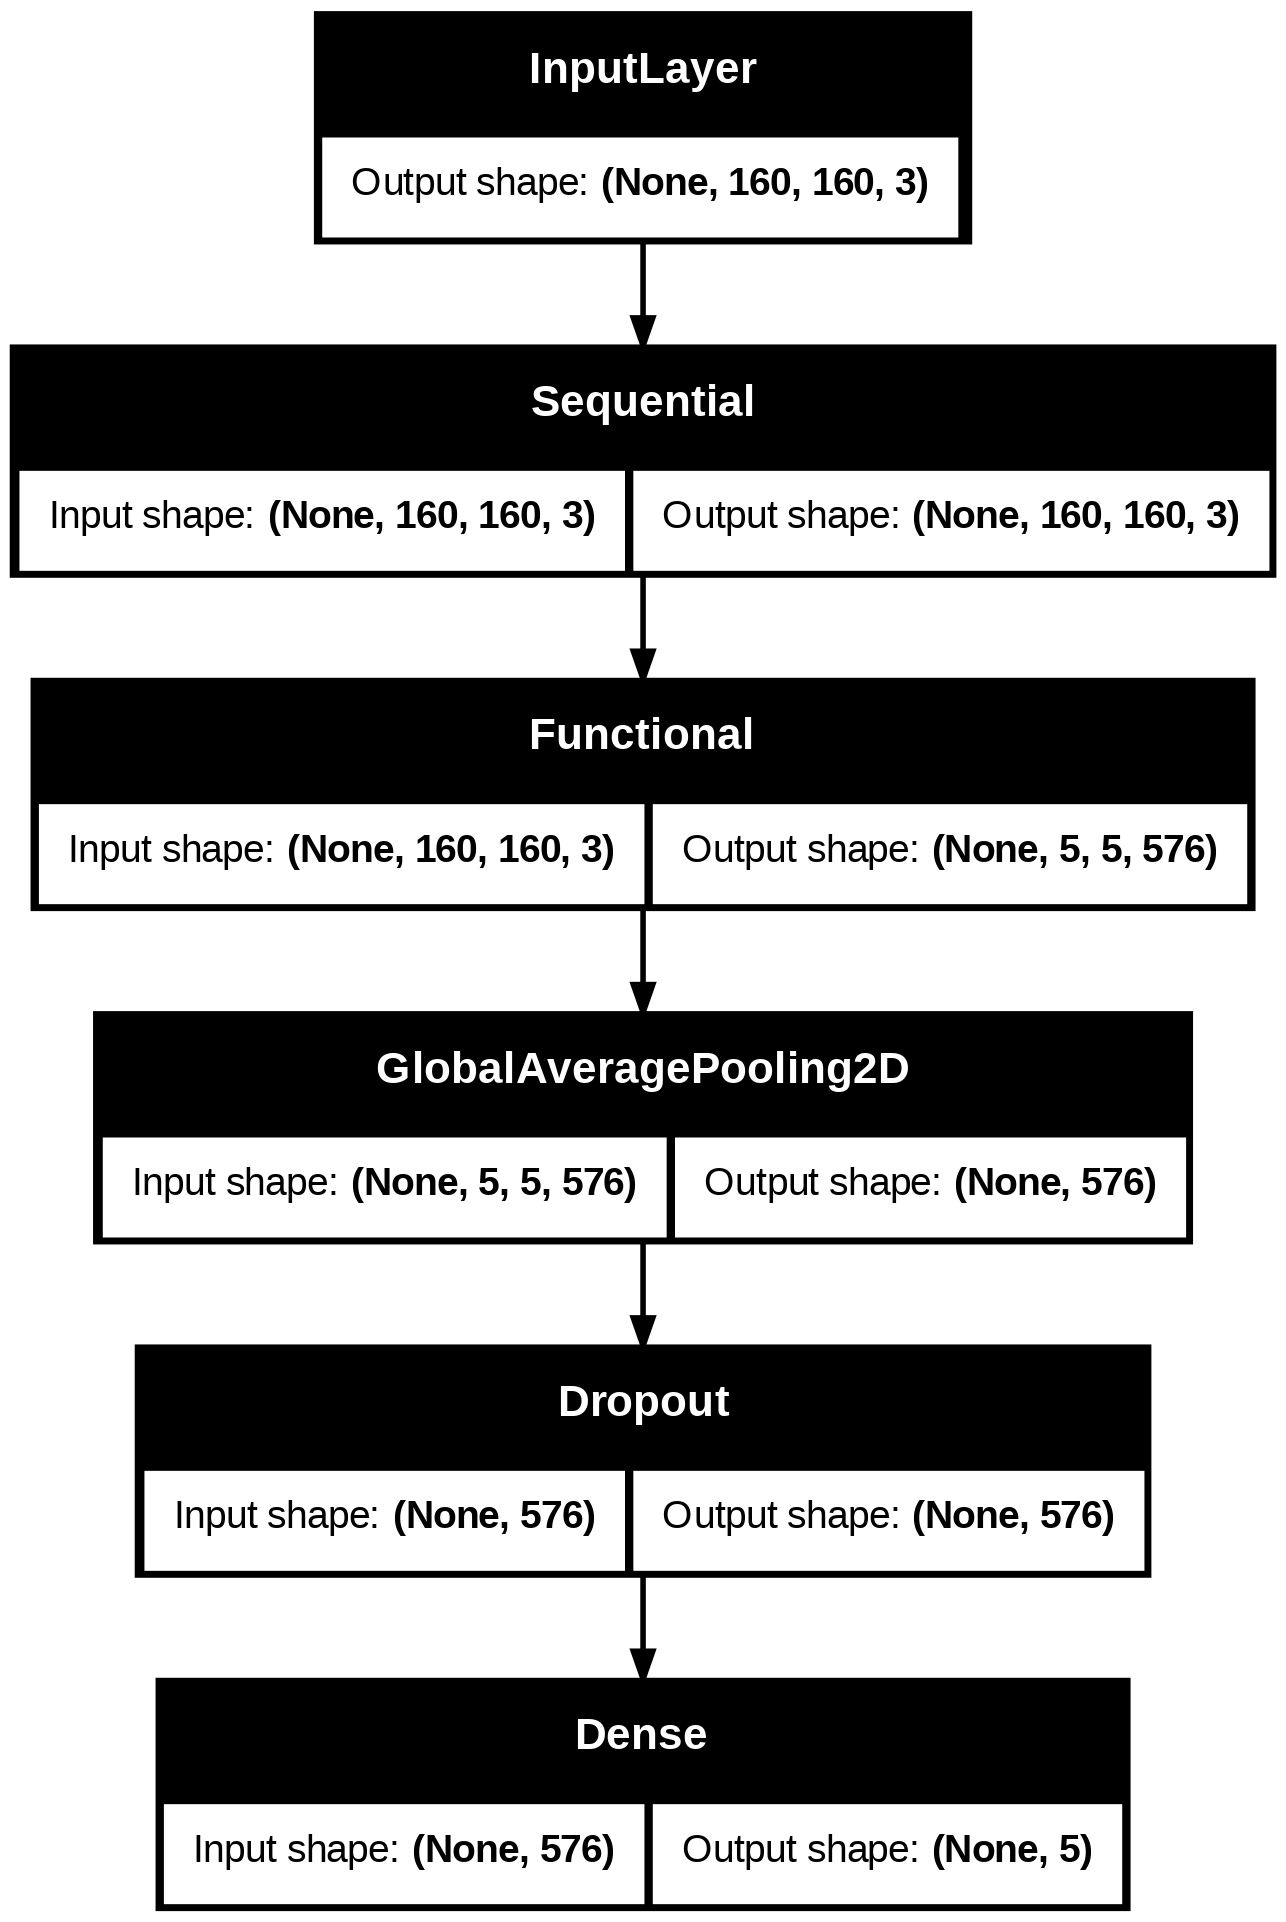

In [101]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

Compile the model

In [102]:
base_learning_rate = 0.0001
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [103]:
initial_epochs = 10

In [104]:
history_1 = model_1.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.2068 - loss: 2.0282 - val_accuracy: 0.2542 - val_loss: 1.7172
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2691 - loss: 1.7315 - val_accuracy: 0.3898 - val_loss: 1.4851
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3659 - loss: 1.5284 - val_accuracy: 0.4695 - val_loss: 1.3162
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4316 - loss: 1.3846 - val_accuracy: 0.5407 - val_loss: 1.1836
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5159 - loss: 1.2334 - val_accuracy: 0.5932 - val_loss: 1.0847
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5834 - loss: 1.1224 - val_accuracy: 0.6373 - val_loss: 1.0087
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5815 - loss: 1.0849 - val_accuracy: 0.6525 - val_loss: 0.9468
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6376 - loss: 1.0152 - val_accuracy: 0.6864 - v

Define `plot_history` function

In [105]:
def plot_history(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

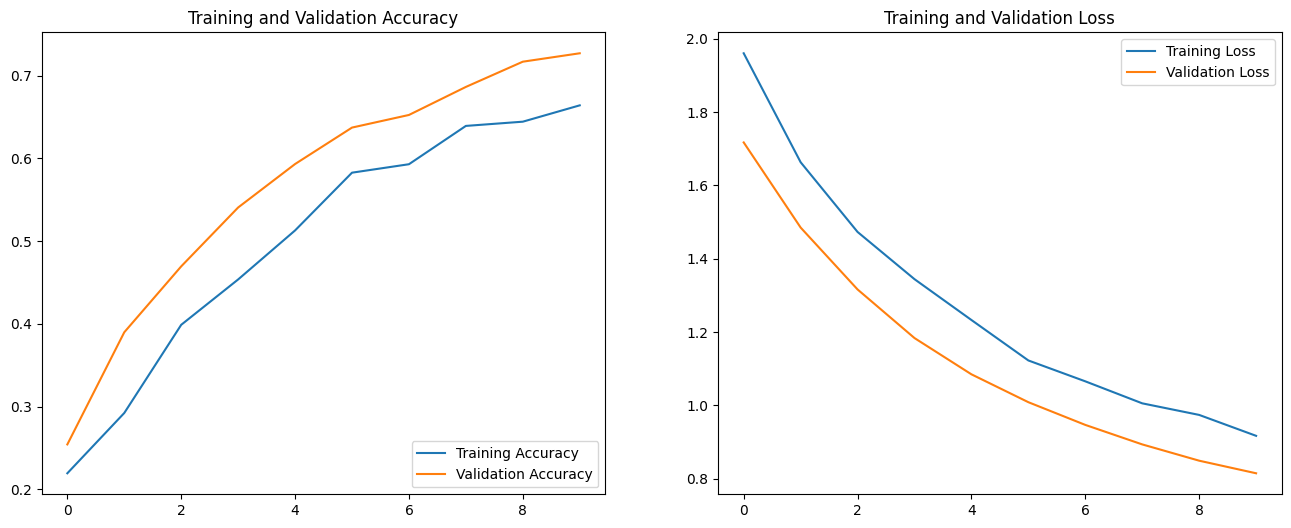

In [106]:
plot_history(history_1, epochs=initial_epochs)

### Fine Tuning

Unfreeze top layers of the model

In [107]:
base_model.trainable = True

Freeze only the bottom layers

In [108]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  157


Compile the model again

In [109]:
model_1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=['accuracy'],
)

In [110]:
model_1.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 5, 5, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │           2,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 942,005 (3.59 MB)

 Trainable params: 758,085 (2.89 MB)

 Non-trainable params: 183,920 (718.44 KB)

In [111]:
len(model_1.trainable_variables)

51

Continue training the model

In [112]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_1_fine = model_1.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history_1.epoch),
    validation_data=val_ds,
)

Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.5912 - loss: 1.0571 - val_accuracy: 0.7492 - val_loss: 0.7680
Epoch 12/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6175 - loss: 1.0306 - val_accuracy: 0.7627 - val_loss: 0.7263
Epoch 13/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6825 - loss: 0.8966 - val_accuracy: 0.7678 - val_loss: 0.6885
Epoch 14/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6549 - loss: 0.9055 - val_accuracy: 0.7831 - val_loss: 0.6558
Epoch 15/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6930 - loss: 0.8096 - val_accuracy: 0.7898 - val_loss: 0.6263
Epoch 16/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7106 - loss: 0.7932 - val_accuracy: 0.8051 - val_loss: 0.5999
Epoch 17/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7096 - loss: 0.7724 - val_accuracy: 0.8136 - val_loss: 0.5755
Epoch 18/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7418 - loss: 0.7059 - val_accuracy: 0

In [113]:
def plot_fine_history(history, history_fine, initial_epochs, final_epochs):
  epochs = initial_epochs + final_epochs
  acc = history.history['accuracy'] + history_fine.history['accuracy']
  val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

  loss = history.history['loss'] + history_fine.history['loss']
  val_loss = history.history['val_loss'] + history_fine.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 8))
  plt.subplot(2, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

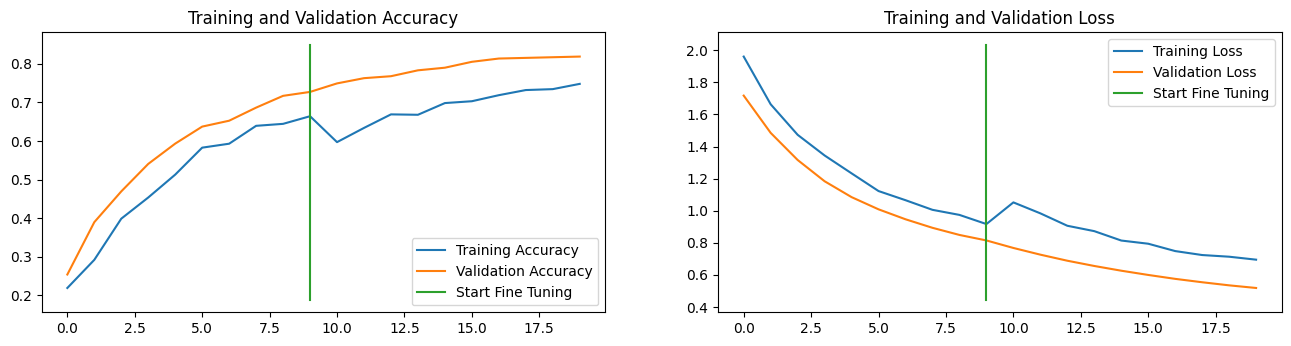

In [114]:
plot_fine_history(
    history=history_1,
    history_fine=history_1_fine,
    initial_epochs=initial_epochs,
    final_epochs=fine_tune_epochs,
)

Evaluate the prediction

In [115]:
loss, accuracy = model_1.evaluate(test_ds)
print('Test accuracy :', accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7852 - loss: 0.4855 
Test accuracy : 0.7708333134651184


Predictions:
 (36, 5)
Labels:
 (36,)


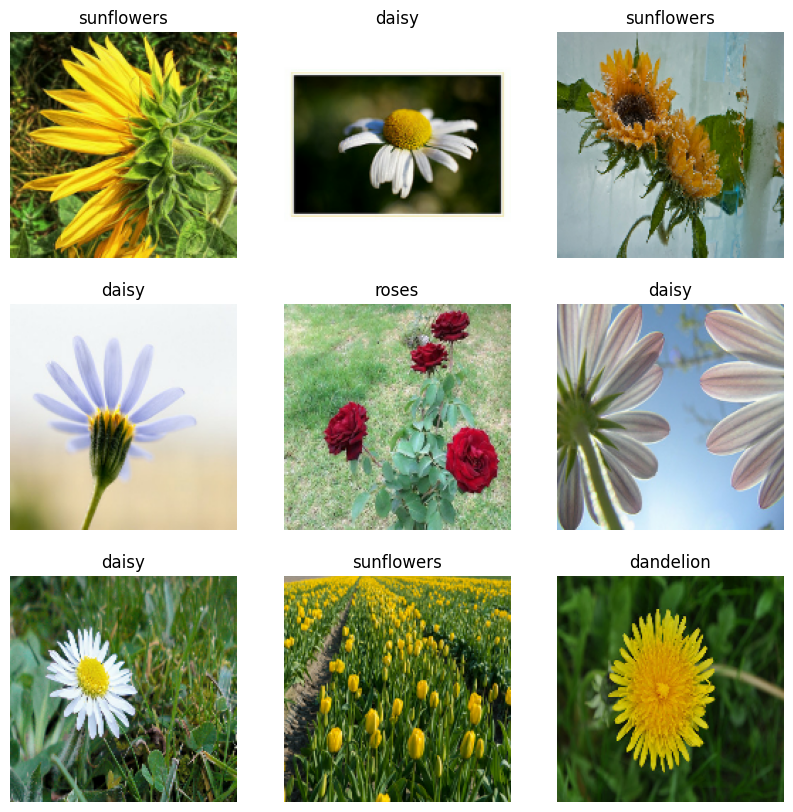

In [121]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model_1.predict_on_batch(image_batch)

print('Predictions:\n', predictions.shape)
print('Labels:\n', label_batch.shape)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[np.argmax(predictions[i])])
  plt.axis("off")

## Train the other models

MobileNetV3Large

In [122]:
base_model_2 = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [123]:
base_model_2.trainable = False

In [124]:
base_model_2.summary()

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 160, 160, 3)    │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 80, 80, 16)     │            432 │ rescaling_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 80, 80, 16)     │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_54             │ (None, 80, 80, 16)     │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 16)     │            144 │ activation_54[0][0]    │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_42 (ReLU)           │ (None, 80, 80, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            256 │ re_lu_42[0][0]         │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 80, 80, 16)     │              0 │ activation_54[0][0],   │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 80, 80, 64)     │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 80, 80, 64)     │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_43 (ReLU)           │ (None, 80, 80, 64)     │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depth

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

In [130]:
prediction_layer_2 = tf.keras.layers.Dense(num_classes)

In [131]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
y = data_augmentation(inputs)
y = process_input(y)
y = base_model_2(y, training=False)
y = global_average_layer(y)
y = dropout_layer(y)
outputs = prediction_layer_2(y)

model_2 = tf.keras.Model(inputs, outputs)

In [132]:
model_2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 5, 5, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           4,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,001,157 (11.45 MB)

 Trainable params: 4,805 (18.77 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [133]:
len(model_2.trainable_variables)

2

In [134]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [135]:
history_2 = model_2.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.2607 - loss: 2.0511 - val_accuracy: 0.3576 - val_loss: 1.5569
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3536 - loss: 1.5853 - val_accuracy: 0.4966 - val_loss: 1.2391
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4995 - loss: 1.3068 - val_accuracy: 0.6203 - val_loss: 1.0342
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5421 - loss: 1.1968 - val_accuracy: 0.7034 - val_loss: 0.9016
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6017 - loss: 1.0644 - val_accuracy: 0.7373 - val_loss: 0.8095
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6461 - loss: 0.9423 - val_accuracy: 0.7644 - val_loss: 0.7393
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6711 - loss: 0.8680 - val_accuracy: 0.7814 - val_loss: 0.6852
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6917 - loss: 0.8199 - val_accuracy: 0.7881 - 

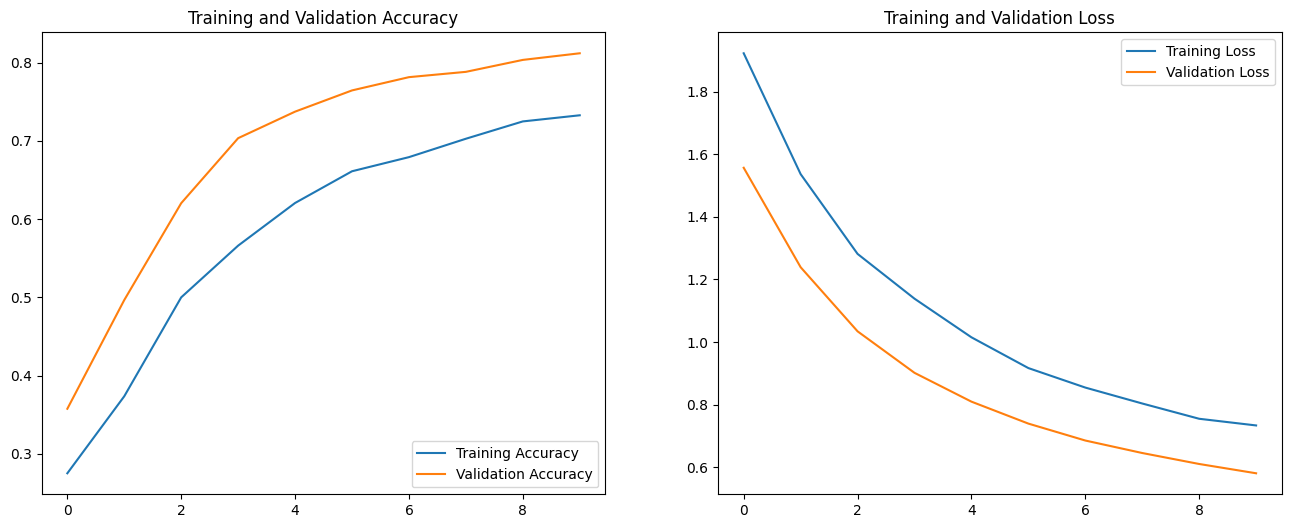

In [136]:
plot_history(history_2, epochs=initial_epochs)

In [137]:
base_model_2.trainable = True

In [140]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model_2.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_2.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  187


In [141]:
model_2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=['accuracy'],
)

In [142]:
model_2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 5, 5, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           4,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,001,157 (11.45 MB)

 Trainable params: 2,816,805 (10.75 MB)

 Non-trainable params: 184,352 (720.12 KB)

In [143]:
len(model_2.trainable_variables)

79

In [144]:
history_2_fine = model_2.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history_2.epoch),
    validation_data=val_ds,
)

Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.6408 - loss: 0.9216 - val_accuracy: 0.8169 - val_loss: 0.5461
Epoch 12/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.6870 - loss: 0.8323 - val_accuracy: 0.8169 - val_loss: 0.5197
Epoch 13/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.7031 - loss: 0.8073 - val_accuracy: 0.8220 - val_loss: 0.4968
Epoch 14/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.7403 - loss: 0.7072 - val_accuracy: 0.8237 - val_loss: 0.4733
Epoch 15/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.7583 - loss: 0.6350 - val_accuracy: 0.8305 - val_loss: 0.4523
Epoch 16/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.7896 - loss: 0.5713 - val_accuracy: 0.8373 - val_loss: 0.4316
Epoch 17/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.7934 - loss: 0.5640 - val_accuracy: 0.8525 - val_loss: 0.4140
Epoch 18/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8103 - loss: 0.5085 - val_accuracy: 

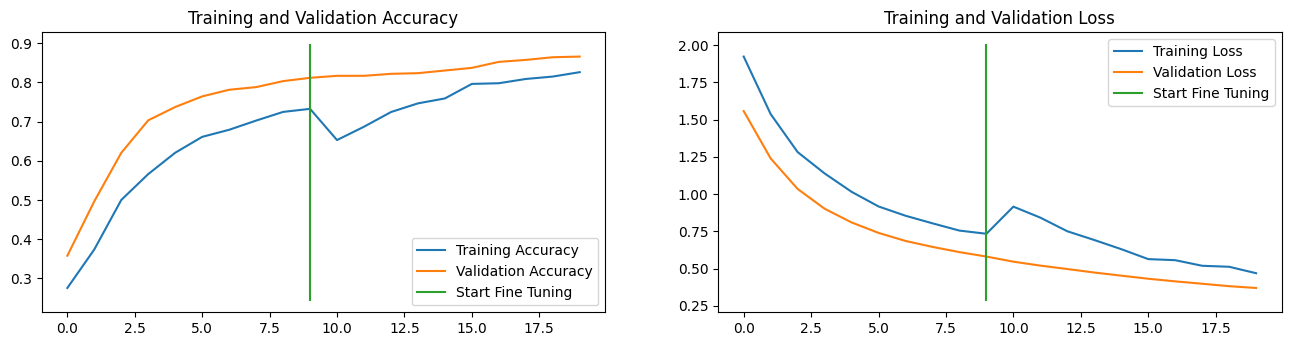

In [145]:
plot_fine_history(
    history=history_2,
    history_fine=history_2_fine,
    initial_epochs=initial_epochs,
    final_epochs=fine_tune_epochs,
)

Define a function for training models more efficiently

In [172]:
def train_model(base_model: tf.keras.Model, initial_epochs=10, fine_epochs=10, learning_rate=base_learning_rate):
  # First, freeze the pre-trained model
  base_model.trainable = False

  # Define the custom model using functional api
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  y = data_augmentation(inputs)
  y = process_input(y)
  y = base_model(y, training=False)
  y = global_average_layer(y)
  y = dropout_layer(y)
  outputs = tf.keras.layers.Dense(num_classes)(y)

  model = tf.keras.Model(inputs, outputs)

  # Compile the model for the first step
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy'],
  )

  # Fit the model without modifying the weights
  history = model.fit(
      train_ds,
      epochs=initial_epochs,
      validation_data=val_ds,
  )

  # Unfreeze the base model
  base_model.trainable = True

  # Fine-tune from this layer onwards
  fine_tune_at = 100

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  # Compile the model again with unfreezed top layers
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate/10),
      metrics=['accuracy'],
  )

  # Fine-tune the model
  history_fine = model.fit(
      train_ds,
      epochs=initial_epochs+fine_epochs,
      initial_epoch=len(history.epoch),
      validation_data=val_ds,
  )

  # Plot the results
  epochs = initial_epochs + fine_epochs

  acc = history.history['accuracy'] + history_fine.history['accuracy']
  val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

  loss = history.history['loss'] + history_fine.history['loss']
  val_loss = history.history['val_loss'] + history_fine.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(18, 8))

  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  # Retrieve a batch of images from the test set
  image_batch, label_batch = test_ds.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch)

  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[np.argmax(predictions[i])])
    plt.axis("off")

  loss, accuracy = model.evaluate(test_ds)
  print('Test accuracy :', accuracy)

  return model

Train the MobileNetV3Large again with 10, 10 epochs

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.2885 - loss: 1.8546 - val_accuracy: 0.4424 - val_loss: 1.4188
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4061 - loss: 1.4937 - val_accuracy: 0.5746 - val_loss: 1.1380
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5213 - loss: 1.2402 - val_accuracy: 0.6458 - val_loss: 0.9636
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.5756 - loss: 1.0867 - val_accuracy: 0.6949 - val_loss: 0.8452
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6521 - loss: 0.9559 - val_accuracy: 0.7373 - val_loss: 0.7608
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6467 - loss: 0.9034 - val_accuracy: 0.7678 - val_loss: 0.7020
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7047 - loss: 0.8125 - val_accuracy: 0.7797 - val_loss: 0.6524
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7153 - loss: 0.7939 - val_accuracy: 0.7949 - 

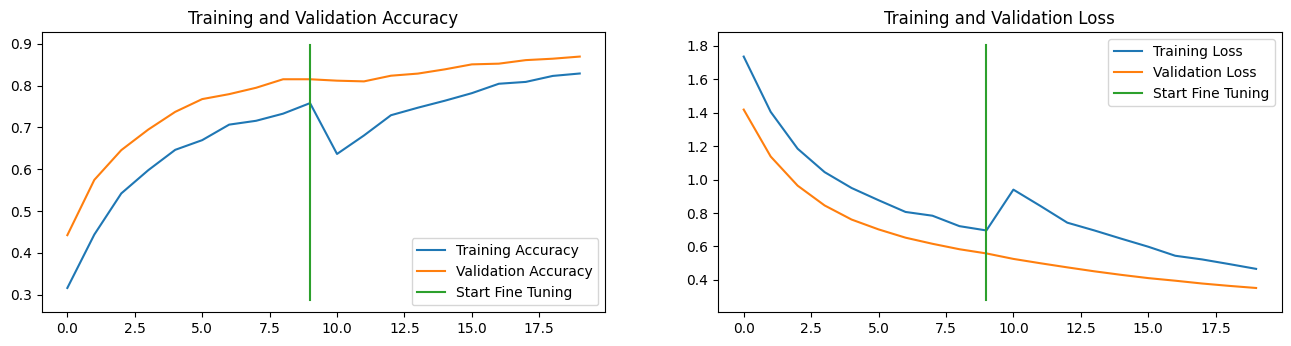

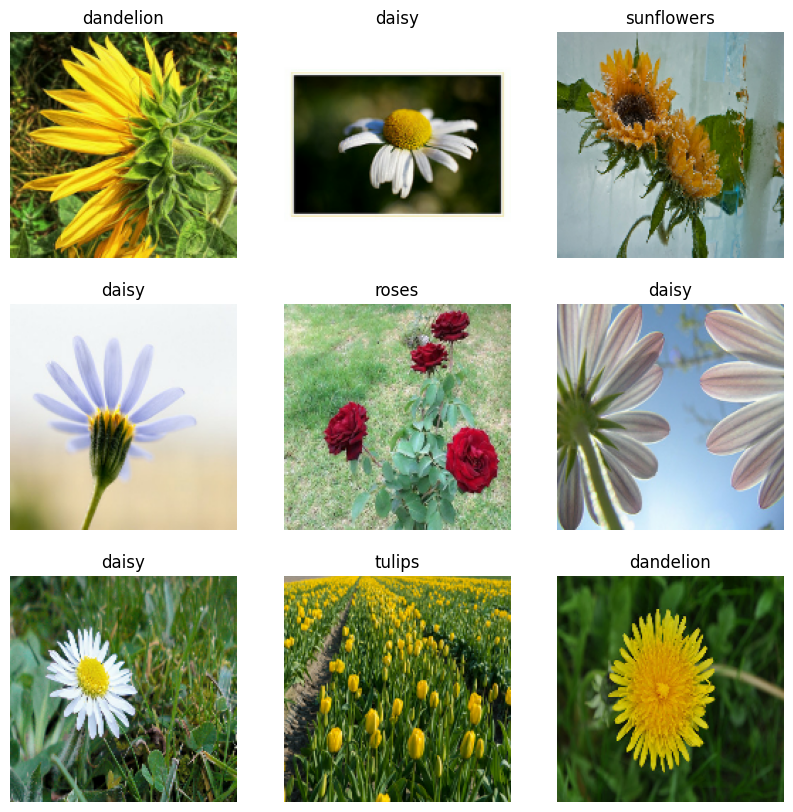

In [150]:
# Re-import the MobileNetV3Large again for fine-tuning
base_model_3 = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

model_3 = train_model(base_model=base_model_3, initial_epochs=10, fine_epochs=10)

Train the MobileNetV3Large again with 15, 15 epochs

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.2263 - loss: 2.1728 - val_accuracy: 0.3186 - val_loss: 1.6415
Epoch 2/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3500 - loss: 1.6420 - val_accuracy: 0.4814 - val_loss: 1.3141
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.4743 - loss: 1.3325 - val_accuracy: 0.5695 - val_loss: 1.1002
Epoch 4/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5007 - loss: 1.2265 - val_accuracy: 0.6373 - val_loss: 0.9547
Epoch 5/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5846 - loss: 1.0676 - val_accuracy: 0.7000 - val_loss: 0.8502
Epoch 6/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6168 - loss: 1.0093 - val_accuracy: 0.7458 - val_loss: 0.7757
Epoch 7/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6667 - loss: 0.8747 - val_accuracy: 0.7610 - val_loss: 0.7188
Epoch 8/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7070 - loss: 0.8369 - val_accuracy: 0.7797 - 

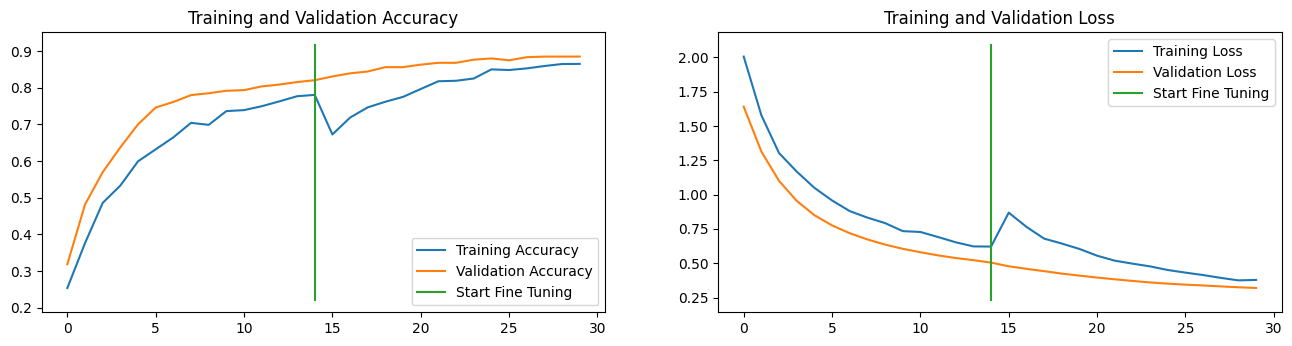

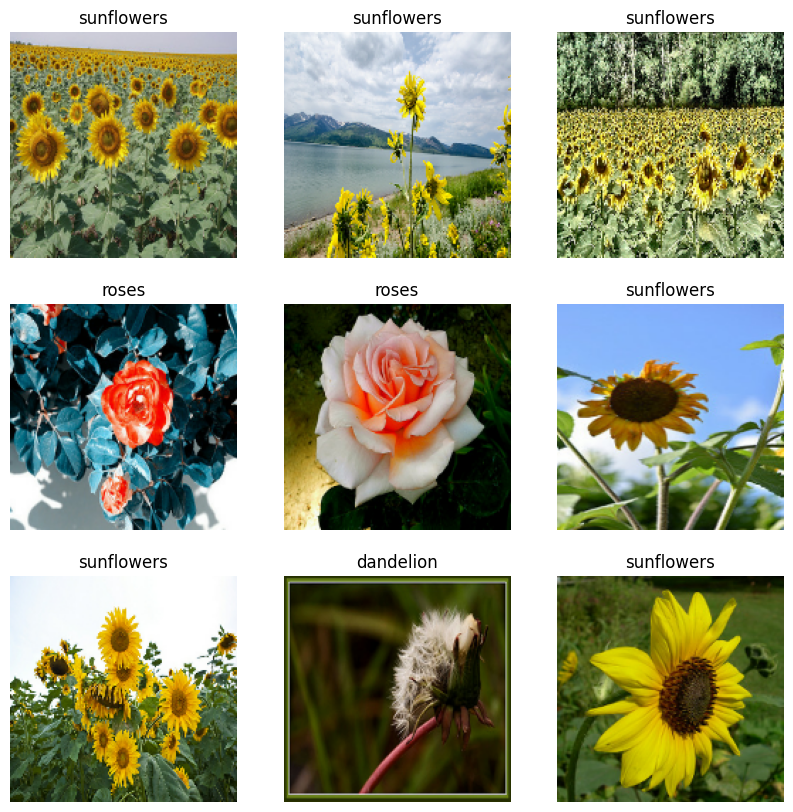

In [151]:
# Re-import the MobileNetV3Large again for fine-tuning
base_model_4 = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

model_4 = train_model(base_model=base_model_4, initial_epochs=15, fine_epochs=15)

Train the MobileNetV3Large again with 30, 30 epochs

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.1708 - loss: 2.1556 - val_accuracy: 0.2915 - val_loss: 1.6470
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2913 - loss: 1.7064 - val_accuracy: 0.4695 - val_loss: 1.3221
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.4216 - loss: 1.4186 - val_accuracy: 0.5847 - val_loss: 1.1154
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5412 - loss: 1.1908 - val_accuracy: 0.6508 - val_loss: 0.9664
Epoch 5/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6022 - loss: 1.0695 - val_accuracy: 0.6831 - val_loss: 0.8646
Epoch 6/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6256 - loss: 0.9775 - val_accuracy: 0.7034 - val_loss: 0.7859
Epoch 7/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6805 - loss: 0.8809 - val_accuracy: 0.7407 - val_loss: 0.7266
Epoch 8/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7266 - loss: 0.8014 - val_accuracy: 0.7559 - 

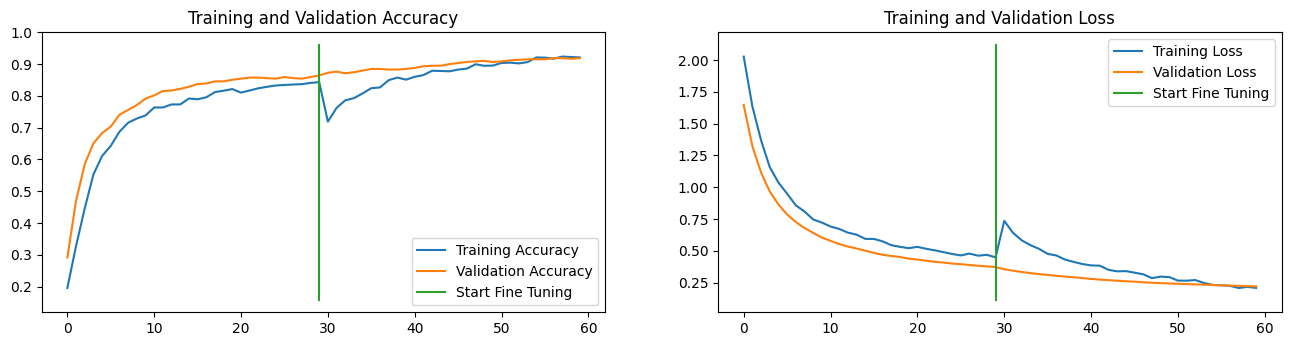

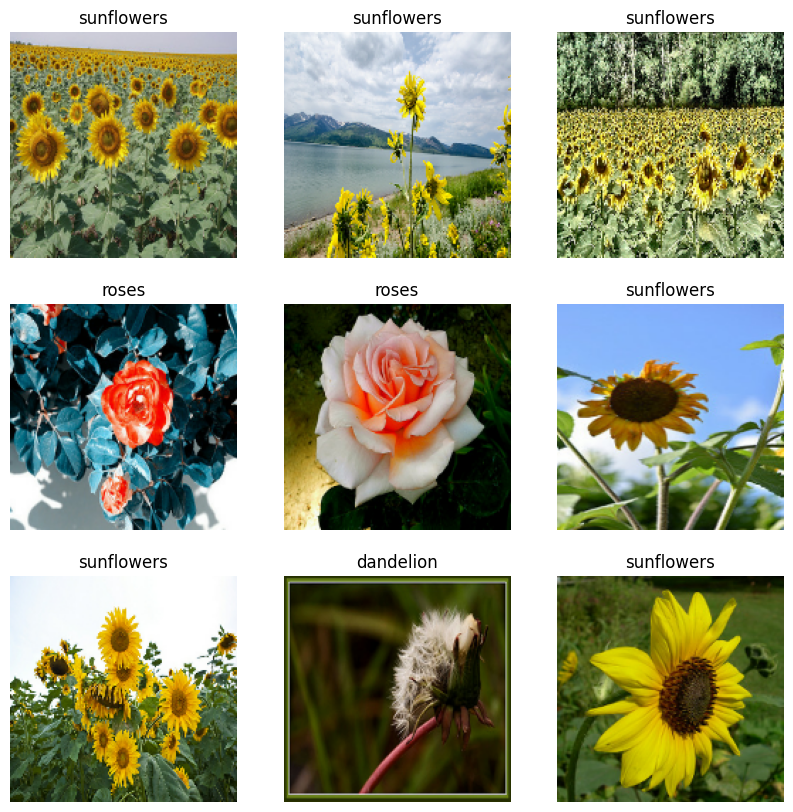

In [152]:
# Re-import the MobileNetV3Large again for fine-tuning
base_model_5 = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

model_5 = train_model(base_model=base_model_5, initial_epochs=30, fine_epochs=30)

Train the MobileNetV3Large again with 50, 50 epochs

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.2572 - loss: 1.9419 - val_accuracy: 0.3898 - val_loss: 1.4632
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4041 - loss: 1.4714 - val_accuracy: 0.5458 - val_loss: 1.2013
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4956 - loss: 1.2547 - val_accuracy: 0.6186 - val_loss: 1.0202
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5761 - loss: 1.0895 - val_accuracy: 0.6661 - val_loss: 0.8998
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6171 - loss: 0.9743 - val_accuracy: 0.7017 - val_loss: 0.8128
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6644 - loss: 0.8872 - val_accuracy: 0.7237 - val_loss: 0.7484
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6861 - loss: 0.8332 - val_accuracy: 0.7356 - val_loss: 0.6979
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6938 - loss: 0.8122 - val_accuracy: 0.7508 - 

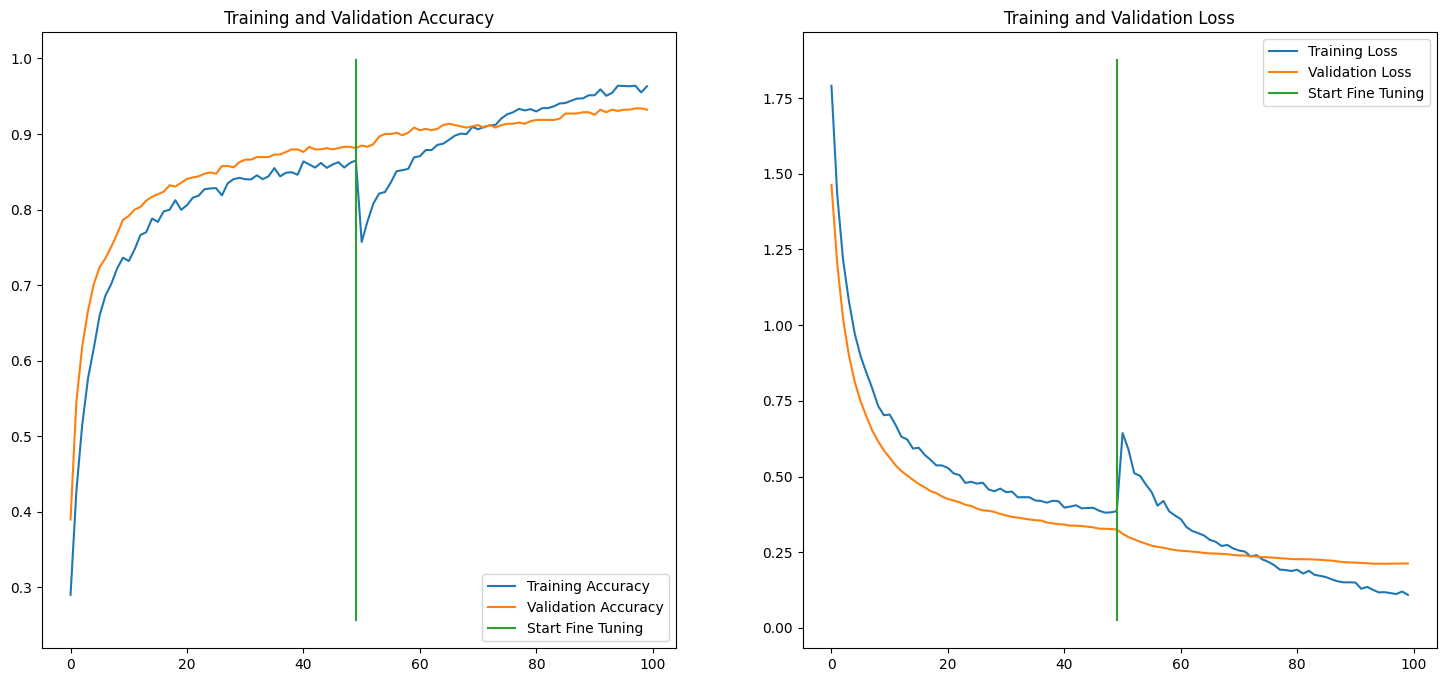

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9620 - loss: 0.1215
Test accuracy : 0.9583333134651184


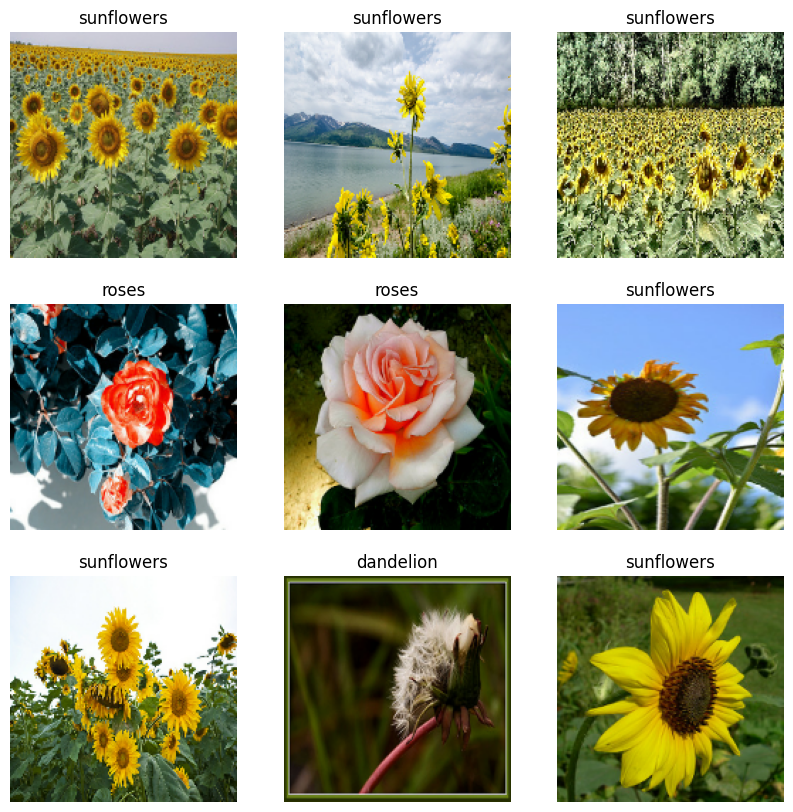

In [173]:
# Re-import the MobileNetV3Large again for fine-tuning
base_model_6 = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

model_6 = train_model(base_model=base_model_6, initial_epochs=50, fine_epochs=50)